In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from Loader.ReadCSV import Reader


In [2]:
data = Reader.read_file(timeframe="H1").dropna()[["Open","High","Low","Close"]]
data.head()

,Open,High,Low,Close
datetime,,,,
2023-05-01 00:00:00,1.10106,1.10143,1.10045,1.10055
2023-05-01 01:00:00,1.10055,1.10084,1.10020,1.10040
2023-05-01 02:00:00,1.10037,1.10081,1.10007,1.10081
2023-05-01 03:00:00,1.10081,1.10140,1.10053,1.10140
2023-05-01 04:00:00,1.10143,1.10143,1.10032,1.10062


In [3]:
from feature_engineering.pipelines.AlphaPlusPipeline import ap_pipeline_x_expanded
data_features = ap_pipeline_x_expanded.fit_transform(data).dropna()
data_features.head()

,Open,High,Low,Close,aws_5_34,kma_10_2_20,ppo_26_12_9,roc_12,rsi_14,srsi_14_3_4,srsi_14_3_4_d,srsi_14_3_4_k,bbh_50_2.0,bbl_50_2.0,bbh_15_1.5,bbl_15_1.5
datetime,,,,,,,,,,,,,,,,
2023-05-03 01:00:00,1.10173,1.10240,1.10128,1.10227,0.002543,1.100370,0.079393,0.724638,65.320631,1.000000,0.967294,1.000000,1.102948,1.095071,1.102602,1.096089
2023-05-03 02:00:00,1.10228,1.10258,1.10197,1.10253,0.002822,1.100759,0.089982,0.419885,66.244846,1.000000,0.988093,1.000000,1.103088,1.095011,1.103015,1.096445
2023-05-03 03:00:00,1.10252,1.10297,1.10251,1.10294,0.003132,1.101297,0.100217,0.299186,67.706396,1.000000,0.998436,1.000000,1.103267,1.094933,1.103246,1.097203
2023-05-03 04:00:00,1.10294,1.10294,1.10212,1.10216,0.003296,1.101392,0.101438,0.198185,62.189603,0.517817,0.959818,0.839272,1.103355,1.094899,1.102717,1.098775
2023-05-03 05:00:00,1.10217,1.10263,1.10182,1.10200,0.003334,1.101436,0.100076,0.207326,61.089996,0.421709,0.871445,0.646509,1.103396,1.094882,1.102678,1.099358


In [14]:
def df_to_X_y(df, window_size=5, max_periods = 10,sl=0.0015,tp=0.0015):
    df_as_np=df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_as_np)-window_size):
        row=[a for a in df_as_np[i:i+window_size]]
        X.append(row)

        open_price = df_as_np[i+window_size][3]
        sl_price = open_price*(1-sl)
        tp_price = open_price*(1+tp)
        hist = df_as_np[i+window_size:i+window_size+max_periods]
        val=[0,1,0]
        for i in hist:
            current_price=i[3]
            if current_price>tp_price:
                val=[0,0,1]
                break
            elif current_price<sl_price:
                val=[1,0,0]
                break
        y.append(val)

    return np.array(X),np.array(y)
X,y=df_to_X_y(data_features)

In [15]:
y.sum(axis=0)

array([1072, 1037,  954])

In [16]:
def separate(X,y,pct_train=0.7,pct_val=0.1):
    pivot_train = int(len(X)*pct_train)
    pivot_val = int(len(X)*(pct_val+pct_train))
    X_train = X[:pivot_train]
    y_train = y[:pivot_train]
    X_val = X[pivot_train:pivot_val]
    y_val=y[pivot_train:pivot_val]
    X_test = X[pivot_val:]
    y_test=y[pivot_val:]
    return X_train,y_train,X_val,y_val,X_test,y_test

X_train,y_train,X_val,y_val,X_test,y_test = separate(X,y)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


cp = ModelCheckpoint('model1/',save_best_only=True)

model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32,"relu"))
model.add(Dense(16,"sigmoid"))
model.add(Dense(3,"softmax"))
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CategoricalCrossentropy(), metrics=CategoricalAccuracy())


In [19]:
history = model.fit(x=X_train,y=y_train,epochs=10,validation_data=(X_val,y_val),shuffle=False,callbacks=[cp])

Epoch 1/10
65/67 [============================>.] - ETA: 0s - loss: 1.1264 - categorical_accuracy: 0.3346INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


67/67 [==============================] - 10s 99ms/step - loss: 1.1262 - categorical_accuracy: 0.3302 - val_loss: 1.0881 - val_categorical_accuracy: 0.3301
Epoch 2/10
67/67 [==============================] - 1s 15ms/step - loss: 1.1065 - categorical_accuracy: 0.3200 - val_loss: 1.0895 - val_categorical_accuracy: 0.4216
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 1.1004 - categorical_accuracy: 0.3396 - val_loss: 1.0913 - val_categorical_accuracy: 0.4216
Epoch 4/10
67/67 [==============================] - 1s 15ms/step - loss: 1.0976 - categorical_accuracy: 0.3363 - val_loss: 1.0921 - val_categorical_accuracy: 0.3791
Epoch 5/10
67/67 [==============================] - 1s 14ms/step - loss: 1.0958 - categorical_accuracy: 0.3685 - val_loss: 1.0920 - val_categorical_accuracy: 0.3595
Epoch 6/10
67/67 [==============================] - 1s 14ms/step - loss: 1.0944 - categorical_accuracy: 0.3755 - val_loss: 1.0918 - val_categorical_accuracy: 0.3497
Epoch 7/10
67/67 [==

Text(0.5, 1.0, 'Model fitting performance')

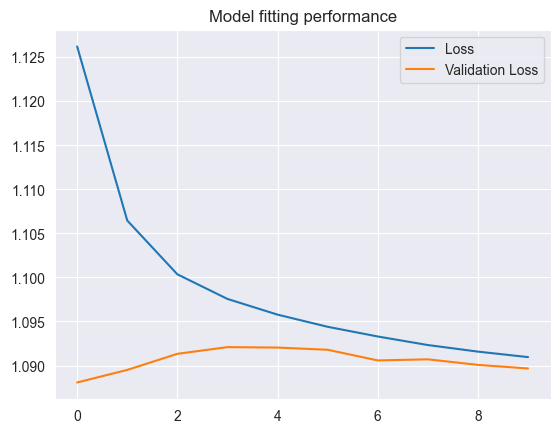

In [20]:
axes=plt.axes()
axes.plot(pd.DataFrame(model.history.history)['loss'], label='Loss')
axes.plot(pd.DataFrame(model.history.history)['val_loss'], label='Validation Loss')
axes.legend(loc=0)
axes.set_title('Model fitting performance')

In [21]:
model1=load_model('model1/')

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
def evaluate(y_pred,y_true):
    # Convert one-hot encoded predictions to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Convert one-hot encoded true labels to class labels
    y_true_labels = np.argmax(y_true, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    # Calculate precision, recall, and F1-score for each class
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Confusion Matrix:")
    class_labels = ['Sell', 'Nothing', 'Buy']
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()


20/20 [==============================] - 1s 6ms/step
Accuracy: 0.32300163132137033
Precision: 0.20599443916971824
Recall: 0.32300163132137033
F1-score: 0.2511259801372964
Confusion Matrix:


C:\Users\mi compu\Desktop\Programacion\python\FXMLlab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


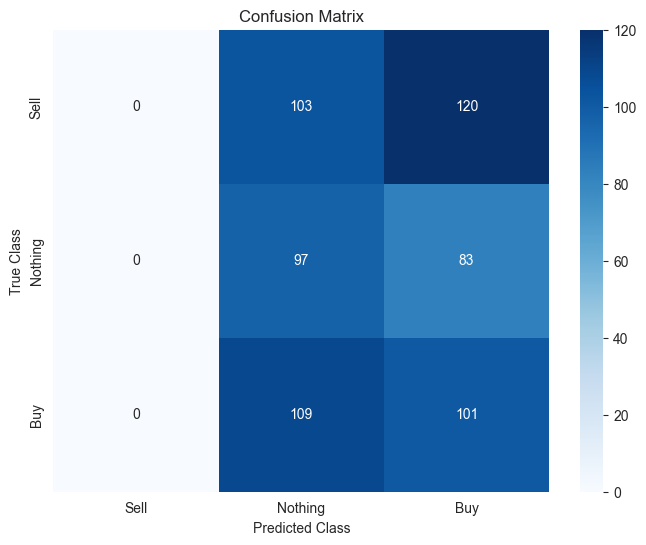

In [23]:
Y_test_predicted = model1.predict(X_test)
Y_test_true=(y_test.reshape(y_test.shape[0],3))
evaluate(Y_test_predicted,Y_test_true)


10/10 [==============================] - 0s 7ms/step
Accuracy: 0.3300653594771242
Precision: 0.25752072929549097
Recall: 0.3300653594771242
F1-score: 0.2746552481632955
Confusion Matrix:


C:\Users\mi compu\Desktop\Programacion\python\FXMLlab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


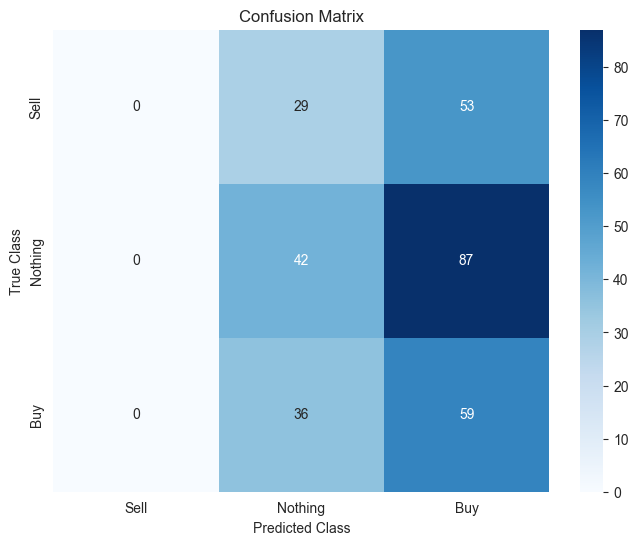

In [24]:
Y_val_predicted_best_model=model1.predict(X_val)
Y_val_true=(y_val.reshape(y_val.shape[0],3))
evaluate(Y_val_predicted_best_model,Y_val_true)

20/20 [==============================] - 0s 7ms/step
Accuracy: 0.32300163132137033
Precision: 0.20599443916971824
Recall: 0.32300163132137033
F1-score: 0.2511259801372964
Confusion Matrix:


C:\Users\mi compu\Desktop\Programacion\python\FXMLlab\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


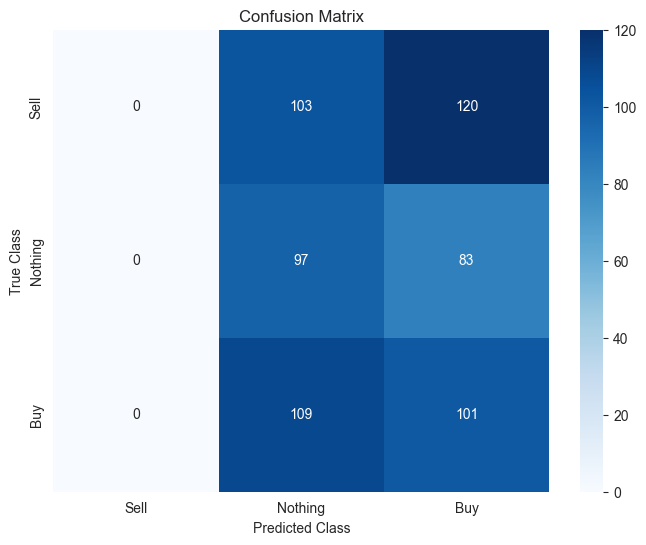

In [25]:
Y_predicted_best_model=model1.predict(X_test)
Y_true=(y_test.reshape(y_test.shape[0],3))
evaluate(Y_predicted_best_model,Y_true)